In [1]:
import numpy as np
from numpy import array as arr
from scipy import odr
from scipy.stats import chi2

import pap   # für Tests

# Fits und Chi-Tests-Entwicklung

In [2]:
'''
Benötigt:
* numpy als np
* scipy.odr als odr

* pap.chi_quadrat_odr()
'''


def odr_fit(funktion, messpunkte, messfehler, parameter0, 
            print_resultate = True, output_chi_test = False, funktionstyp = 'x, *p'):
    '''
    Orthogonal Distance Regression - Fittet eine 1D-Funktion an fehlerbehaftete Messdaten an. Im Gegensatz 
    zu curve_fit() aus scipy.stats werden hier auch Fehler in der x-Achse berücksichtigt. Eigentlich wird 
    hier nur das scipy.odr-Paket in einer einfach zu bedienenden aber optionsärmeren Funktion verpackt.
    
    Optional werden die Fit-Resultate angezeigt und returned, ebenso ein optionaler χ^2-Test.
    
    
    Argumente
    ---------
    funktion : function
        Erlaubt sind mathematische |R -> |R Funktionen. Folgende Argumente-Reihenfolgen sind unterstützt:
        funktion(x, *parameter)  also bspw. pap.quad_func(x, a, b, c)
        funktion(x, parameter)   parameter : array_like
        funktion(parameter, x)   parameter : array_like
        Der verwendete Typ muss unter  funktionstyp  angegeben werden.
    
    messpunkte : np.array (2D, mit number_like Elementen)
        Form: np.array([x_werte_liste, y_werte_liste])
    
    messfehler : np.array (2D, mit number_like Elementen > 0)
        Form: np.array([x_fehler_liste, y_fehler_liste])
    
    Natürlich müssen alle vier Listen gleich lang sein.
    
    parameter0 : array_like (1D, mit number_like Elementen)
        Erste Schätzung, für was die gefitteten Parameter sein sollen.
        Achtung! Eine schlechte Schätzung kann dazu führen, dass der Fit schief läuft.
    
    print_resultate : bool, optional
        Bei  True  wird eine Zusammenfassung der Fitergebnisse geprintet (pprint() aus scipy.odr),
        siehe  Beispiele  und  Bedeutung des Fit-Resultates.
        Bei  False  wird nichts geprintet.
    
    output_chi_test : bool, string, optional
        Bei  False  wird der χ^2-Wert des Fits nicht returned,
        bei  True  schon.
        Bei  'print'  wird ein χ^2-Test direkt ausgeführt und geprintet (pap.chi_quadrat_odr()),
        siehe  Beispiele  und Dokumentation von  pap.chi_quadrat_odr()
    
    funktionstyp : string, optional
        Ist standardmäßig auf  'x, *p',  also die Form  funktion(x, *parameter)  eingestellt.
        Wähle  'x, p_list'  für Form  funktion(x, parameter)
        oder   'p_list, x'  für Form  funktion(parameter, x).
    
    
    Output
    ------
    parameter : np.array (1D, float Elemente)
        Liste der Parameter der gefitteten Funktion
    
    paramter_fehler : np.array (1D, float Elemente)
        Liste von deren 1σ-Fehlern (Standardabweichungen)
    
    chi_quadrat_liste : list, optional
        Besteht aus 
        chi_quadrat : float, 
        anzahl_messwerte : int,
        anzahl_parameter : int
        Kann man direkt in  pap.chi_quadrat_odr()  einfügen, siehe  Beispiele.
        
    
    Beispiele
    ---------
    Hier werden sowohl Fit-Resultate als auch χ^2-Wert angezeigt:
    >>> messpunkte = np.array([[0.9, 2.3, 4.5], [-2.0, -4.3, -8.6]])
    >>> messfehler = np.array([[0.1, 0.05, 0.08], [0.1, 0.4, 0.3]])
    >>> parameter_schätz  = [-2]
    >>> parameter, parameter_fehler = pap.odr_fit(pap.prop_func, messpunkte, messfehler, 
                                                  parameter_schätz,output_chi_test = 'print')
      Ergebnisse des ODR-Fits:

      Beta: [-1.93158386]
      Beta Std Error: [0.05977981]
      Beta Covariance: [[0.00435563]]
      Residual Variance: 0.8204606240877614
      Inverse Condition #: 1.0
      Reason(s) for Halting:
        Sum of squares convergence


      Ergebnisse des χ^2-Tests:

      χ^2_reduziert         = 0.82
      Fitwahrscheinlichkeit = 44.0%
    
    
    Hier ohne Prints aber mit χ^2-Output:
    >>> output = pap.odr_fit(pap.poly_func, messpunkte, messfehler, parameter_schätz, 
                             print_resultate = False, output_chi_test = True, funktionstyp = 'x, p_list')
    >>> parameter, parameter_fehler, chi_quadrat_liste = output
    
    Damit kann man dann den χ^2-Test separat ausführen:
    >>> pap.chi_quadrat_odr(*chi_quadrat_liste)
      Ergebnisse des χ^2-Tests:

      χ^2_reduziert         = 0.82
      Fitwahrscheinlichkeit = 44.0%
    
    
    Bedeutung des Fit-Resultates
    ----------------------------
      * "Beta" und "Beta Std Error" sind jeweils die Parameter und deren 1σ-Fehler der gefitteten 
        Funktion. Sie heißen im Output  parameter  und  parameter_fehler.
      * "Beta Covariance" ist die Kovarianz-Matrix der Parameter.
      * "Residual Variance" ist der reduzierte χ^2-Wert des Fits. Er taucht auch im Ergebnis des χ^2-Testes
        auf.
      * "Reason(s) for Halting" kann Gründe angeben, warum ein Fit schiefgelaufen ist. 
        "Sum of squares convergence" bedeutet, dass die Optimierfunktion auf einen bestimmten Wert 
        konvergiert ist. Bedeutet aber nicht notwendigerweise, dass die die gefunden Parameter sinnvoll 
        sind, dies sieht man besser mit einem Plot
    '''
    
    
    
    # Überprüfen und Anpassen der Argumente
    x_werte,  y_werte  = messpunkte
    x_fehler, y_fehler = messfehler
    
    if messfehler[messfehler == 0].size != 0:
        print('messfehler darf keine Fehler enthalten, die 0 sind!')
        return
    
    def funktion_kompatibel(parameter, x):
        if funktionstyp == 'x, *p':
            return funktion(x, *parameter)
        elif funktionstyp == 'x, p_list':
            return funktion(x, parameter)
        elif funktionstyp == 'p_list, x':
            return funktion(parameter, x)
        else:
            print('funktionstyp ist falsch angegeben. >:(')
            return
    
    
    # Berechnung des Fits
    modell_funktion = odr.Model(funktion_kompatibel)
    messdaten       = odr.RealData(x_werte, y_werte, x_fehler, y_fehler)
    regression      = odr.ODR(messdaten, modell_funktion, beta0 = parameter0)
    ergebnis        = regression.run()
    
    
    # Einstellen des Outputs und Print-Inhaltes
    return_list = []
    return_list.append(ergebnis.beta)
    return_list.append(ergebnis.sd_beta)
    
    if print_resultate == True:
        print('Ergebnisse des ODR-Fits:\n')
        ergebnis.pprint()
        
    if output_chi_test != False:
        chi_quadrat = ergebnis.sum_square
        anzahl_messwerte = np.shape(messpunkte)[1]
        anzahl_parameter = len(ergebnis.beta)
        chi_test_list = [chi_quadrat, anzahl_messwerte, anzahl_parameter]
        if output_chi_test == True:
            return_list.append(chi_test_list)
        elif output_chi_test == 'print':
            print('\n')
            chi_quadrat_odr(*chi_test_list)
    
    return return_list

In [3]:
'''
Benötigt von:
* pap.odr_fit()

Benötigt:
* pap._chi_quadrat_print()
'''


def chi_quadrat_odr(chi_quadrat, anzahl_messwerte, anzahl_parameter):
    '''
    Printet den χ^2_reduziert-Wert und die Fitwahrscheinlichkeit für einen ODR-Fit (siehe pap.odr_fit()).
    Die drei Input-Argumente kann man sich von der pap.odr_fit-Funktion mithilfe der Angabe
    output_chi_test = True  als drittes Output-Argument geben lassen.
    
    Argumente
    ---------
    chi_quadrat : float (> 0)
    
    anzahl_messwerte : int (> 0)

    anzahl_parameter : int (> 0)
    
    
    Beispiel
    --------
    >>> parameter, parameter_fehler, chi_test_liste = pap.odr_fit(... Argumente ..., output_chi_liste = True)
    ... Geprintetes Ergebnis vom ODR-Fit ...
    >>> pap.chi_quadrat_ord(*chi_test_liste)
    Ergebnisse des χ^2-Tests:
    
    χ^2_reduziert         = 0.82
    Fitwahrscheinlichkeit = 44.0%
    '''
    
    
    _chi_quadrat_print(chi_quadrat, anzahl_messwerte, anzahl_parameter)

In [4]:
'''
Benötigt:
* numpy als np

* pap._chi_quadrat_print()
'''


def chi_quadrat_test(fit_werte, werte, werte_fehler, anzahl_parameter): 
    '''
    Printet den χ^2_reduziert-Wert und die Fitwahrscheinlichkeit.
    
    Argumente
    ---------
    fit_werte: np.array (1D, number_like)
        die Werte, die die Fitfunktion ausgibt, also  fit_werte = fit_func(x_werte, *parameter)
    
    werte: np.array (1D, number_like)
        y-Werte der Messdaten
    
    werte_fehler: np.array (1D, number_like)
        y-Fehler der Messdaten
    
    anzahl_parameter : int (> 0)
        Anzahl Parameter der Fitfunktion
        
        
    Beispiele
    ---------
    >>> x_werte = np.array([-8, -5.5, -1.2, 1, 1.4, 3.2, 4.5])
    >>> y_werte = np.array([40, 20.8, 3.1, 0.5, 1.5, 3, 6])
    >>> y_fehler = np.array([0.5, 0.73, 0.42, 0.23, 0.23, 0.41, 0.44])
    >>> fitparameter = [0.46721214, -1.01681483, 1.45102103]
    >>> pap.chi_quadrat_test(pap.quadfunc(x_werte, *fitparameter), y_werte, y_fehler, 3)
      Ergebnisse des χ^2-Tests:

      χ^2_reduziert         = 2.79
      Fitwahrscheinlichkeit = 2.5%
    '''
    
    
    chi_quadrat = np.sum(((fit_werte - werte) / werte_fehler)**2)
    
    _chi_quadrat_print(chi_quadrat, len(werte), anzahl_parameter)

In [5]:
'''
Benötigt von:
* pap.chi_quadrat_odr()
* pap.chi_quadrat_test()

Benötigt:
* scipy.stats.chi2 als chi2
'''


def _chi_quadrat_print(chi_quadrat, anzahl_messwerte, anzahl_parameter):
    '''
    Berechnet χ^2_reduziert und die Fitwahrscheinlichkeit und printet sie als schönes Ergebnis.
    '''
    
    freiheitsgrade         = anzahl_messwerte - anzahl_parameter
    chi_quadrat_reduziert  = chi_quadrat / freiheitsgrade 
    fit_wahrscheinlichkeit = (1 - chi2.cdf(chi_quadrat, freiheitsgrade)) * 100
    
    print('Ergebnisse des χ^2-Tests:\n')
    print(f"χ^2_reduziert         = {chi_quadrat_reduziert:.2f}") 
    print(f"Fitwahrscheinlichkeit = {fit_wahrscheinlichkeit:.1f}%")

## Tests

In [6]:
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt

### Test 1 - Docstring-Beispiel

In [7]:
messpunkte = np.array([[0.9, 2.3, 4.5], [-2.0, -4.3, -8.6]])
messfehler = np.array([[0.1, 0.05, 0.08], [0.1, 0.4, 0.3]])

In [8]:
parameter, parameter_fehler = odr_fit(pap.prop_func, messpunkte, messfehler, arr([-2]), print_resultate = True, 
                                      output_chi_test = 'print')

Ergebnisse des ODR-Fits:

Beta: [-1.93158386]
Beta Std Error: [0.05977981]
Beta Covariance: [[0.00435563]]
Residual Variance: 0.8204606240877614
Inverse Condition #: 1.0
Reason(s) for Halting:
  Sum of squares convergence


Ergebnisse des χ^2-Tests:

χ^2_reduziert         = 0.82
Fitwahrscheinlichkeit = 44.0%


In [9]:
parameter, parameter_fehler, chi_test_list = odr_fit(pap.prop_func, messpunkte, messfehler, arr([-2]), 
                                                     print_resultate = True, 
                                                     output_chi_test = True)

Ergebnisse des ODR-Fits:

Beta: [-1.93158386]
Beta Std Error: [0.05977981]
Beta Covariance: [[0.00435563]]
Residual Variance: 0.8204606240877614
Inverse Condition #: 1.0
Reason(s) for Halting:
  Sum of squares convergence


In [10]:
chi_quadrat_odr(*chi_test_list)

Ergebnisse des χ^2-Tests:

χ^2_reduziert         = 0.82
Fitwahrscheinlichkeit = 44.0%


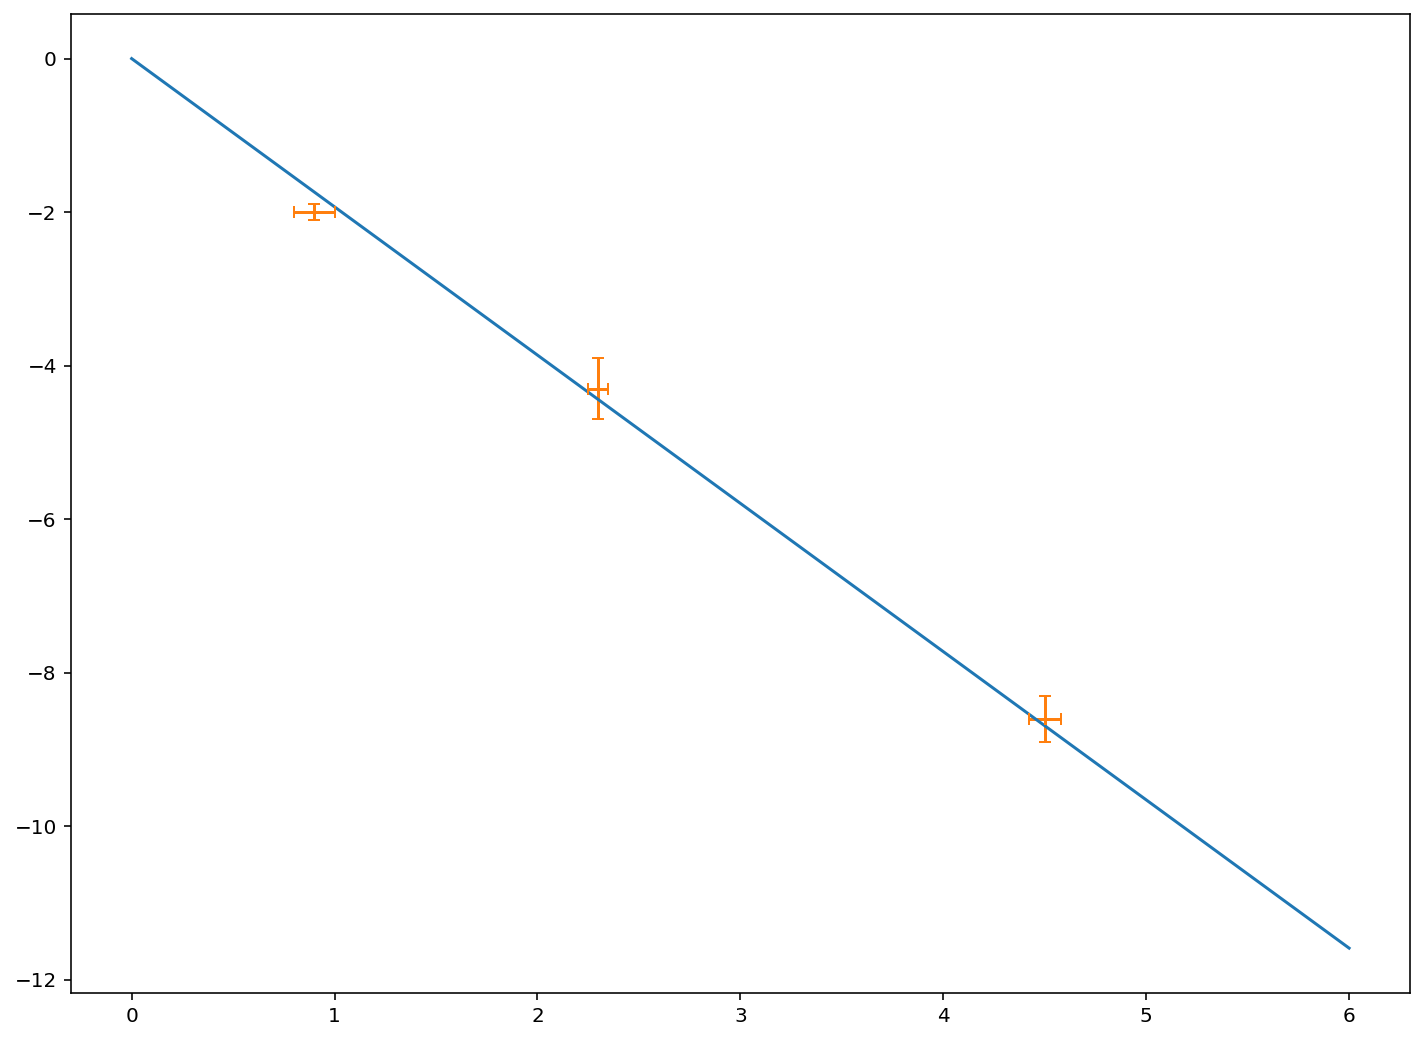

In [11]:
x_werte  = np.linspace(0, 6, 10)
fitwerte = pap.prop_func(x_werte, *parameter)

plt.figure(figsize = (12, 9))
plt.plot(x_werte, fitwerte)
plt.errorbar(messpunkte[0], messpunkte[1], messfehler[1], messfehler[0], fmt = '+', capsize = 3);

### Test 2 - Eine normale Funktion mit recht nahen Messwerten

In [12]:
messpunkte = arr([[-8, -5.5, -1.2, 1, 1.4, 3.2, 4.5], [40, 20.8, 3.1, 0.5, 1.5, 3, 6]])
messfehler = arr([[0.09, 0.05, 0.02, 0.05, 0.03, 0.09, 0.03], [0.5, 0.73, 0.42, 0.23, 0.23, 0.41, 0.44]])
parameter_geschätzt = (0.5, 0., -2.)

In [13]:
output = odr_fit(pap.quad_func, messpunkte, messfehler, parameter_geschätzt, print_resultate = True, 
                 output_chi_test = 'print')
parameter, parameter_fehler = output

Ergebnisse des ODR-Fits:

Beta: [ 0.46721214 -1.01681483  1.45102103]
Beta Std Error: [0.02097659 0.10513108 0.29242765]
Beta Covariance: [[ 0.00017036  0.0003446  -0.00139274]
 [ 0.0003446   0.00427929 -0.0065555 ]
 [-0.00139274 -0.0065555   0.03310905]]
Residual Variance: 2.58279590678155
Inverse Condition #: 0.004080565135018735
Reason(s) for Halting:
  Sum of squares convergence


Ergebnisse des χ^2-Tests:

χ^2_reduziert         = 2.58
Fitwahrscheinlichkeit = 3.5%


In [14]:
chi_quadrat_test(pap.quad_func(messpunkte[0], *parameter), messpunkte[1], messfehler[1], 3)

Ergebnisse des χ^2-Tests:

χ^2_reduziert         = 2.79
Fitwahrscheinlichkeit = 2.5%


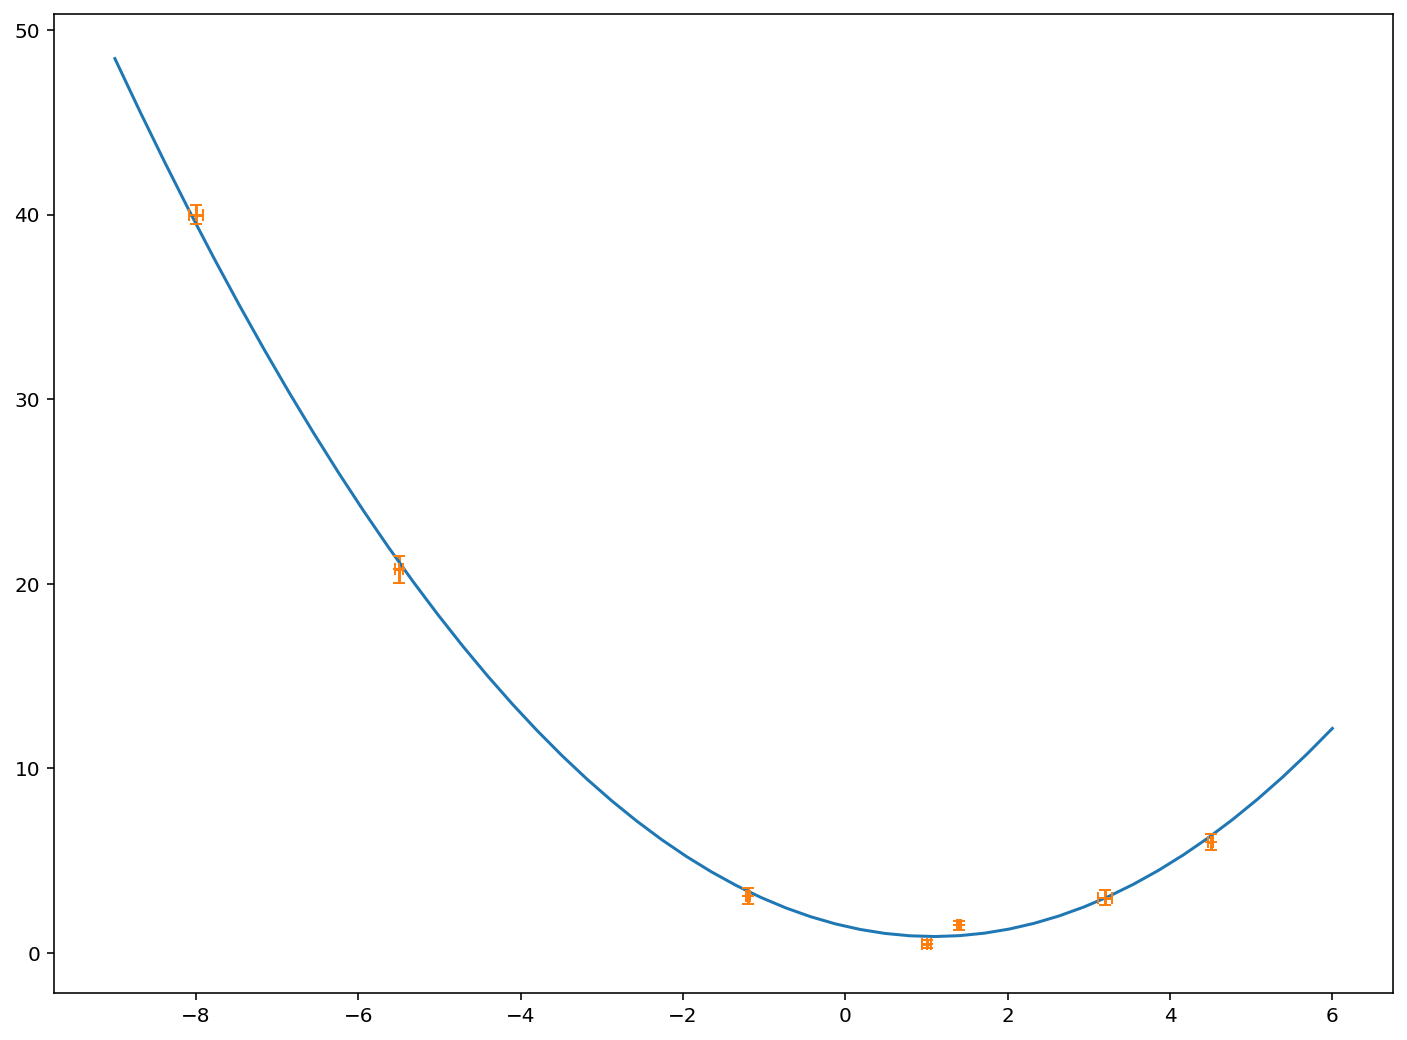

In [15]:
x_werte  = np.linspace(-9, 6, 50)
fitwerte = pap.quad_func(x_werte, *parameter)

plt.figure(figsize = (12, 9))
plt.plot(x_werte, fitwerte)
plt.errorbar(messpunkte[0], messpunkte[1], messfehler[1], messfehler[0], fmt = '+', capsize = 3);

### Test 3 - Eine normale Funktion, die gar nicht zu den Daten passt

In [16]:
messpunkte = arr([[-8.48, -3.5, -2.58, -0, 0.01, 0.2, 9.9], 
                  [-0.01, -0.2, -0.5, -0, 10, 5, 0.05]])
messfehler = arr([[0.3, 0.2, 0.038, 0.3, 0.05, 0.084, 0.34], 
                  [0.05, 0.09, 0.2, 0.3, 1, 0.04, 0.03]])
parameter_geschätzt = [0.1, 0, 0]

In [17]:
output = odr_fit(pap.quad_func, messpunkte, messfehler, parameter_geschätzt, print_resultate = True, 
                 output_chi_test = 'print')
parameter, parameter_fehler = output

Ergebnisse des ODR-Fits:

Beta: [-0.16050546  1.1328029   4.7556646 ]
Beta Std Error: [0.08852606 0.60865079 1.01670295]
Beta Covariance: [[ 6.51925522e-05 -2.23500875e-04 -2.80002878e-04]
 [-2.23500875e-04  3.08171198e-03  1.70336732e-03]
 [-2.80002878e-04  1.70336732e-03  8.59891856e-03]]
Residual Variance: 120.21103315981318
Inverse Condition #: 0.0073411219165845564
Reason(s) for Halting:
  Sum of squares convergence


Ergebnisse des χ^2-Tests:

χ^2_reduziert         = 120.21
Fitwahrscheinlichkeit = 0.0%


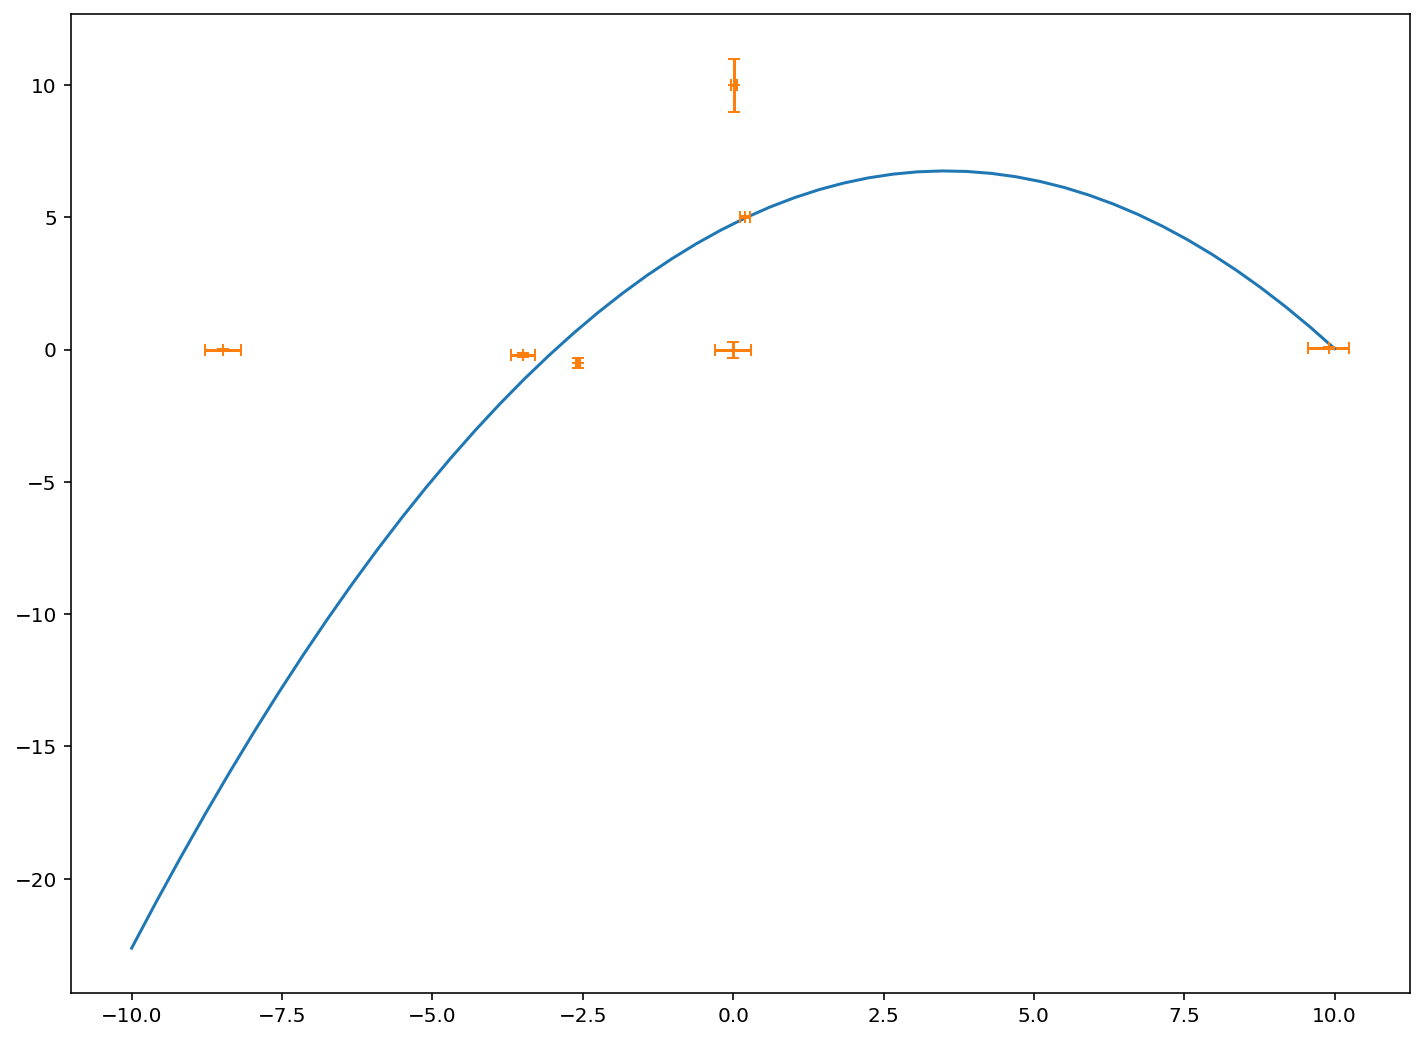

In [18]:
x_werte  = np.linspace(-10, 10, 50)
fitwerte = pap.quad_func(x_werte, *parameter)

plt.figure(figsize = (12, 9))
plt.plot(x_werte, fitwerte)
plt.errorbar(messpunkte[0], messpunkte[1], messfehler[1], messfehler[0], fmt = '+', capsize = 3);

### Test 4 - pap.poly_func

In [19]:
messpunkte = arr([[-8, -5.5, -1.2, 1, 1.4, 3.2, 4.5], [40, 20.8, 3.1, 0.5, 1.5, 3, 6]])
messfehler = arr([[0.09, 0.05, 0.02, 0.05, 0.03, 0.09, 0.03], [0.5, 0.73, 0.42, 0.23, 0.23, 0.41, 0.44]])
parameter_geschätzt = arr([0.5, 0., -2.])

In [20]:
output = odr_fit(pap.poly_func, messpunkte, messfehler, parameter_geschätzt, print_resultate = True, 
                 output_chi_test = 'print', funktionstyp = 'x, p_list')
parameter, parameter_fehler = output

Ergebnisse des ODR-Fits:

Beta: [ 0.46721214 -1.01681483  1.45102103]
Beta Std Error: [0.02097659 0.10513108 0.29242765]
Beta Covariance: [[ 0.00017036  0.0003446  -0.00139274]
 [ 0.0003446   0.00427929 -0.0065555 ]
 [-0.00139274 -0.0065555   0.03310905]]
Residual Variance: 2.58279590678155
Inverse Condition #: 0.004080565135018735
Reason(s) for Halting:
  Sum of squares convergence


Ergebnisse des χ^2-Tests:

χ^2_reduziert         = 2.58
Fitwahrscheinlichkeit = 3.5%


### Test 4 - negative- und 0-Fehler

In [21]:
# 0-Fehler
messpunkte = arr([[-8, -5.5, -1.2, 1, 1.4, 3.2, 4.5], [40, 20.8, 3.1, 0.5, 1.5, 3, 6]])
messfehler = arr([[0.09, 0.05, 0.02, 0.00, 0.03, 0.09, 0.03], [0.5, 0.73, 0.42, 0.23, 0.23, 0.41, 0.44]])
parameter_geschätzt = arr([0.5, 0., -2.])

In [22]:
output = odr_fit(pap.quad_func, messpunkte, messfehler, parameter_geschätzt, print_resultate = True, 
                 output_chi_test = 'print')
# parameter, parameter_fehler = output

messfehler darf keine Fehler enthalten, die 0 sind!


In [23]:
# negative Fehler
messpunkte = arr([[-8, -5.5, -1.2, 1, 1.4, 3.2, 4.5], [40, 20.8, 3.1, 0.5, 1.5, 3, 6]])
messfehler = arr([[-0.09, 0.05, 0.02, -0.01, 0.03, 0.09, 0.03], [0.5, -0.73, 0.42, -0.23, 0.23, -0.41, 0.44]])
parameter_geschätzt = arr([0.5, 0., -2.])

In [24]:
output = odr_fit(pap.quad_func, messpunkte, messfehler, parameter_geschätzt, print_resultate = True, 
                 output_chi_test = 'print')
parameter, parameter_fehler = output

Ergebnisse des ODR-Fits:

Beta: [ 0.46722189 -1.01675409  1.45085788]
Beta Std Error: [0.0209753  0.10512945 0.29236747]
Beta Covariance: [[ 0.00017033  0.00034444 -0.00139191]
 [ 0.00034444  0.00427878 -0.00655128]
 [-0.00139191 -0.00655128  0.03309248]]
Residual Variance: 2.5830258349108353
Inverse Condition #: 0.004080934984536049
Reason(s) for Halting:
  Sum of squares convergence


Ergebnisse des χ^2-Tests:

χ^2_reduziert         = 2.58
Fitwahrscheinlichkeit = 3.5%
